 # Inference using the astrocyte data


 This tutorial demonstrates how to train a GET model to predict expression in ATAC-seq peaks using motif information. We'll cover:

 1. Loading and configuring the model

 2. Finetune from a pretrained expression prediction GET model

 3. Perform various analysis using `gcell` package



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run


/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


 ## Finetune



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial.yaml`

In [2]:
if not Path('./checkpoint-best.pth').exists():
    s3_checkpoint_url = "s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/finetune_fetal_adult_leaveout_astrocyte/checkpoint-best.pth"
    ! aws s3 cp $s3_checkpoint_url ./checkpoint-best.pth --no-sign-request

Download the astrocyte data

In [ ]:
if not Path('astrocyte.zarr').exists():
    ! wget https://zenodo.org/records/14614947/files/astrocyte.zarr.tar?download=1
    ! mv astrocyte.zarr.tar?download=1 astrocyte.zarr.tar
    ! tar -xvf astrocyte.zarr.tar

> Note: In the paper, we mainly used binary ATAC signal trained model for motif interpretation analysis. As it's hard to say whether there are mutual causal relationship between transcription and accessibility. If accessibility is added to the model, potentially it will absorb some TF's effect to itself, thereby making the interpretation more difficult. However, if the goal is to represent the cell states as precisely as possible and use the model for other downstream tasks (e.g. enhancer target prediction), adding the accessibility signal is probably better.

In [10]:
celltype_for_modeling = [
    'astrocyte']
cfg = load_config('finetune_tutorial') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.project_name = 'astrocyte'
cfg.run.run_name = 'astrocyte'
cfg.dataset.quantitative_atac = False # We use binary ATAC signal for motif interpretation analysis
cfg.dataset.zarr_path = "./astrocyte.zarr" # set the path to the data zarr file we just processed
cfg.dataset.celltypes = ','.join(celltype_for_modeling) # the celltypes you want to finetune
cfg.finetune.checkpoint = "./checkpoint-best.pth" # set the path to the pretrained checkpoint we want to finetune from
cfg.dataset.leave_out_celltypes = 'astrocyte' # set the celltypes you want to leave out
cfg.machine.num_devices=1 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=8 # batch size for training; check `nvidia-smi` to see the available GPU memory
# cfg.machine.output_dir = "./output/"
print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /home/xf2217/output/astrocyte/astrocyte
training for 100 epochs


In [11]:
# export the config to a yaml file
from get_model.config.config import export_config, load_config_from_yaml

export_config(cfg, "exported_training_config.yaml")

In [12]:
# load the config from the yaml file
cfg = load_config_from_yaml("exported_training_config.yaml")
cfg.stage='validate'

In [13]:
print(f"Default checkpoint path is at: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}/checkpoints/best.ckpt")
print("The `trainer.checkpoint_callback.best_model_path` variable will be updated to the checkpoint path after training")

Default checkpoint path is at: /home/xf2217/output/astrocyte/astrocyte/checkpoints/best.ckpt
The `trainer.checkpoint_callback.best_model_path` variable will be updated to the checkpoint path after training


Now we can start the finetuning

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


/home/xf2217/Projects/get_model.worktrees/refactor_with_hydra/get_model/utils.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, 

Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


wandb: Currently logged in as: xf2217 (get-v3). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 1/1 [00:00<00:00, 53.80it/s]

Leave out chromosomes: ['chr11']
Input chromosomes: ['chr11']


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        exp_pearson        │    0.9285982847213745     │
│          exp_r2           │    0.8521827459335327     │
│       exp_spearman        │    0.9241099953651428     │
│       val_exp_loss        │    0.1864699423313141     │
│         val_loss          │    0.1864699423313141     │
└───────────────────────────┴───────────────────────────┘

epoch,▁
exp_pearson,▁
exp_r2,▁
exp_spearman,▁
trainer/global_step,▁▁
val_exp_loss,▁
val_loss,▁
epoch,0
exp_pearson,0.9286
exp_r2,0.85218
exp_spearman,0.92411


checkpoint path: 


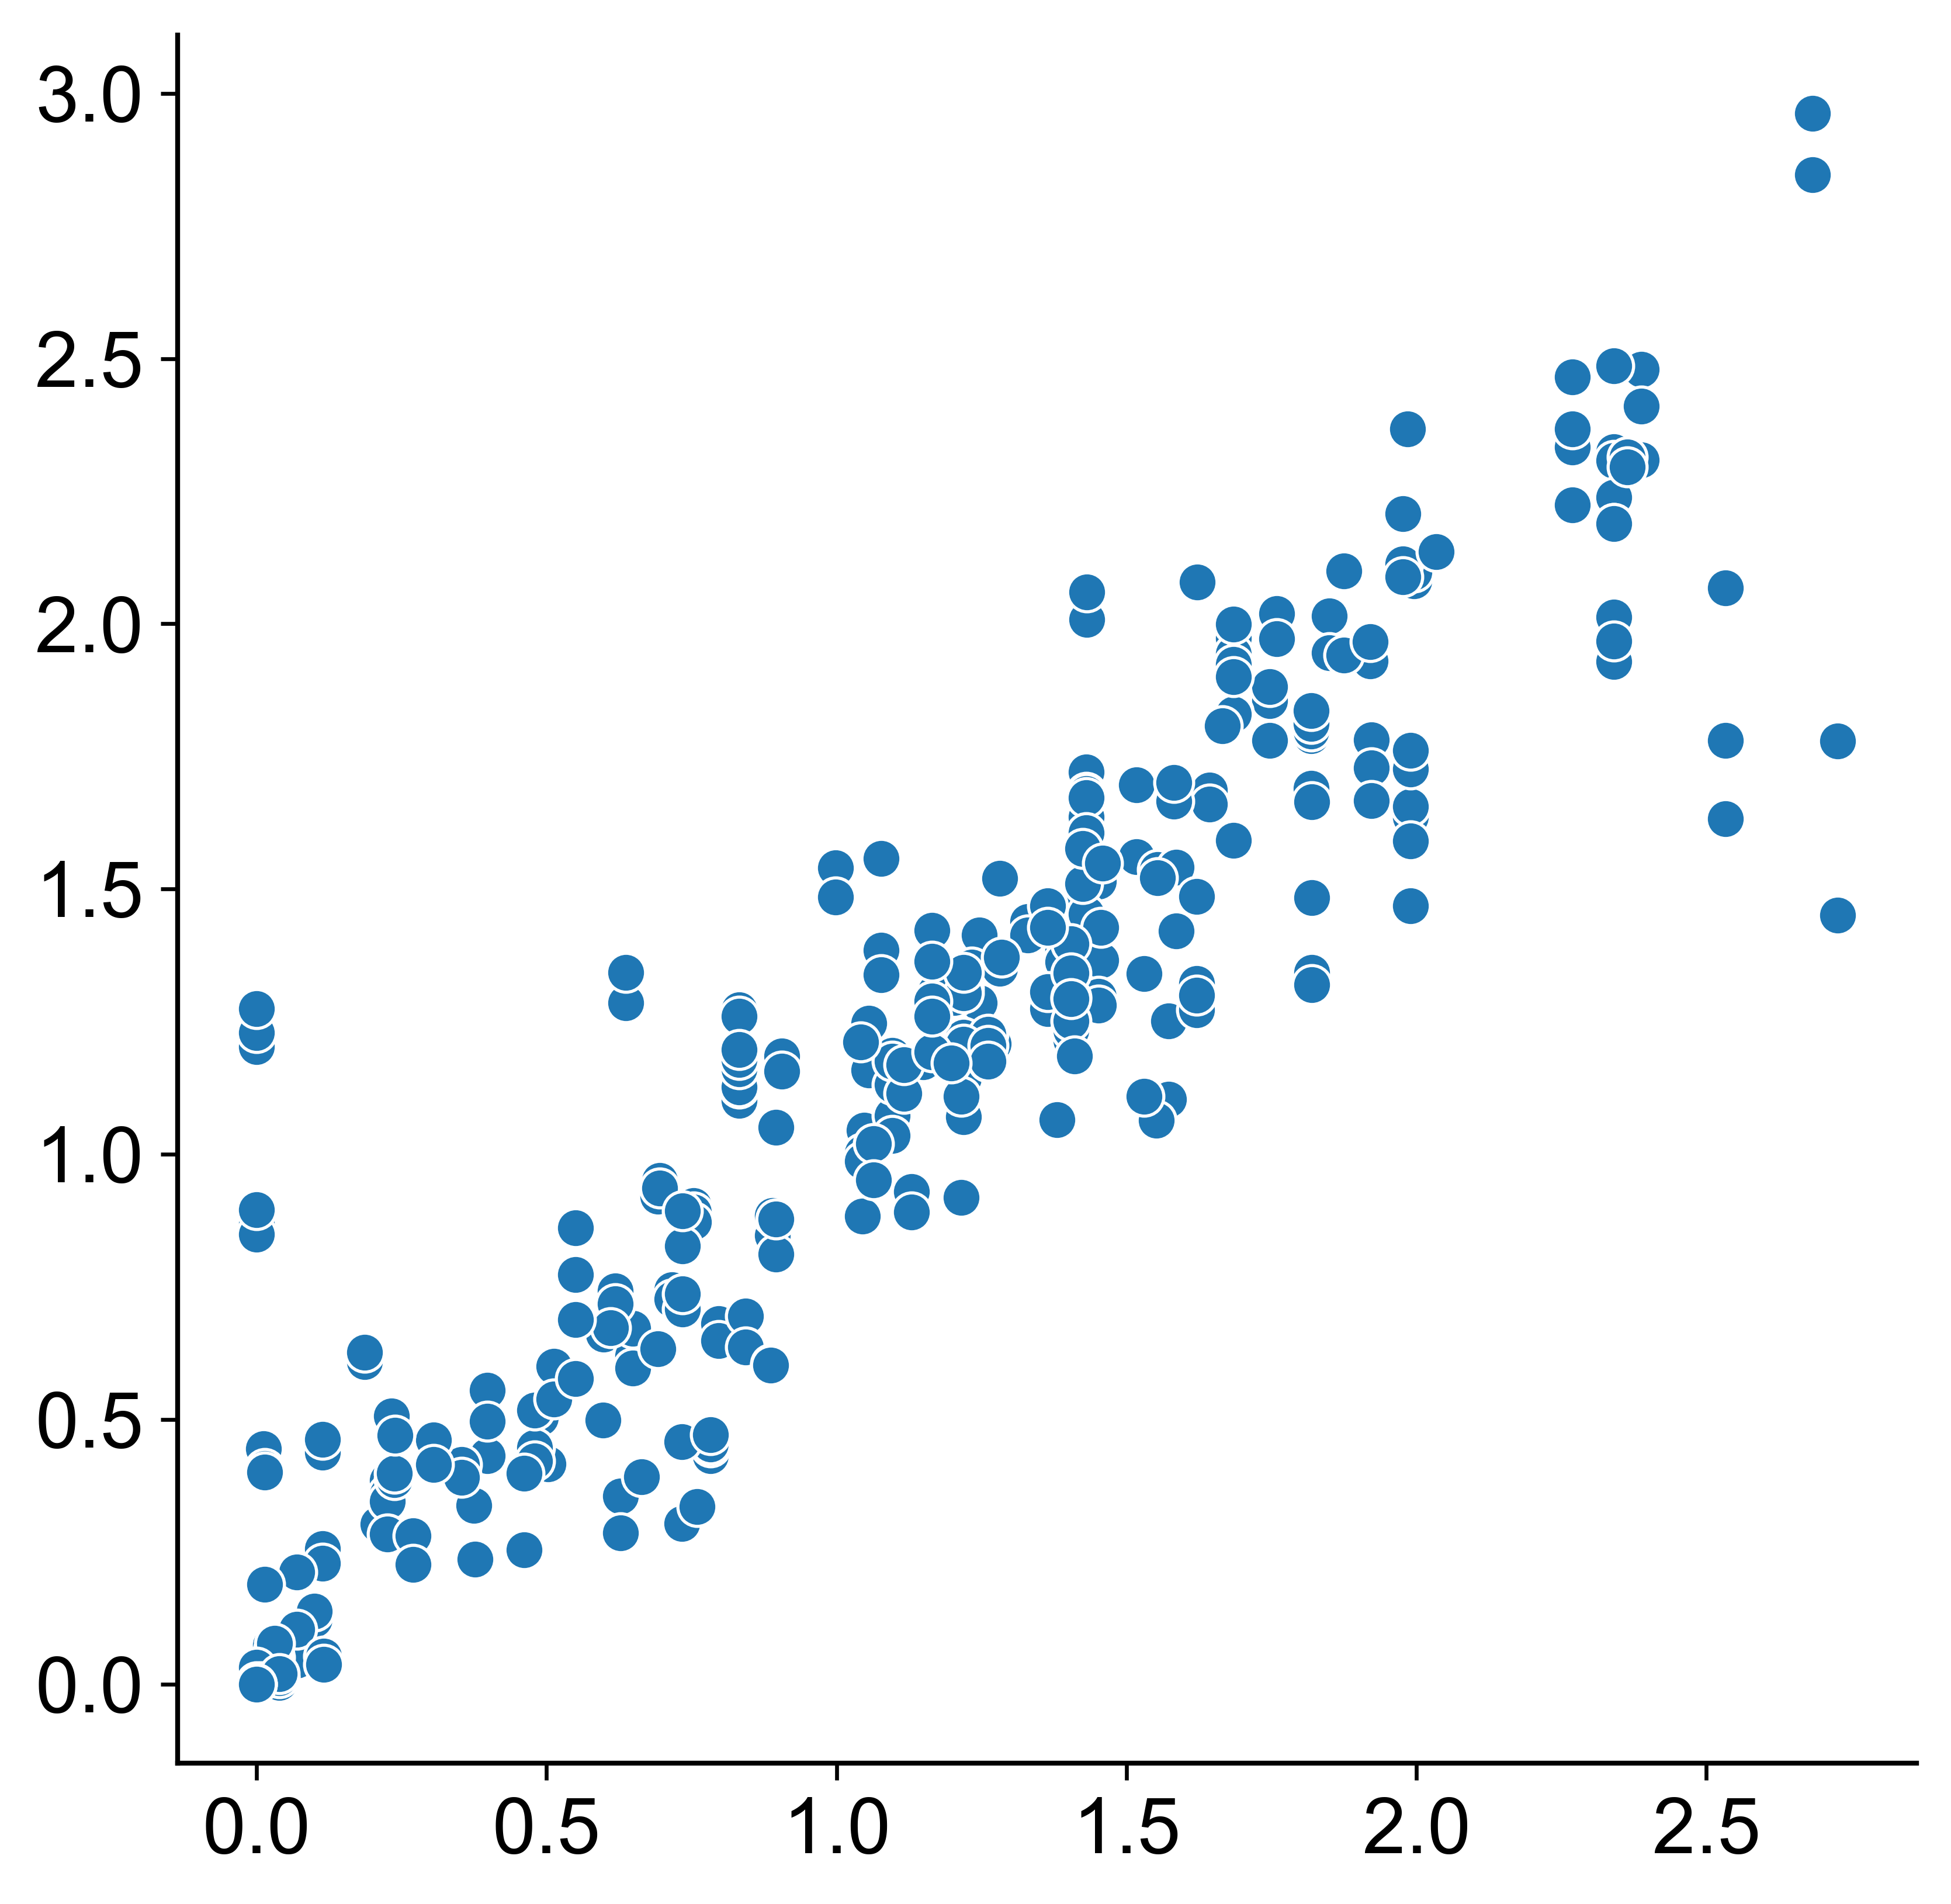

In [14]:
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090
print("checkpoint path:", trainer.checkpoint_callback.best_model_path)